In [ ]:
!pip install wordninja
# !pip install emoji
!pip install regex
# !pip install demoji
!pip install pyLDAvis==3.4.1
!pip install detoxify
!pip install pandas openpyxl xlrd


In [266]:
import pickle
import numpy as np
import pandas as pd
import collections
from collections import Counter
import os

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
cmap = get_cmap('winter')


import re
import emoji 
import demoji
import contractions
from tqdm import tqdm
import wordninja

#nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import PIL
import pyLDAvis
pyLDAvis.enable_notebook()


/tmp/ipykernel_184272/4084337897.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrtcloud-8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mrtcloud-8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mrtcloud-8/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [124]:
#get tweets before war
dir_file = os.getcwd()

files_dir = os.listdir(dir_file)
before_war = "twitter_before.xlsx"
# tweets_before = pd.ExcelFile(before_war)
twitter_before = pd.read_excel(before_war)

#get reddit posts after war began
war_started = "reddit_after.csv"
reddit_after = pd.read_csv(war_started)

In [125]:
print(twitter_before.shape)
print(reddit_after.shape)

(24251, 11)
(436725, 5)


In [4]:
#remove unnecessary columns
twitter_before.drop(['Tweet Id','Place', 'Source', 'Username', 'Likes Number', 'Quote Number', 'Reply Number'], axis=1, inplace=True)
twitter_before = twitter_before.rename(columns={'DateTime': 'date', 'Content': 'text', 'Retweets Number':'retweetNumber'})

reddit_after.drop(['comment_id','score', 'subreddit'], axis=1, inplace=True)
reddit_after = reddit_after.rename(columns={'created_time':'date','self_text': 'text'})
reddit_after = reddit_after.dropna()

In [5]:
reddit_after['date'].value_counts()

date
2023-10-14 15:48:28+00:00    7
2023-10-15 12:30:34+00:00    6
2023-10-14 21:55:45+00:00    6
2023-10-08 20:31:11+00:00    6
2023-10-14 14:06:51+00:00    6
                            ..
2023-10-21 04:48:21+00:00    1
2023-10-21 04:48:29+00:00    1
2023-10-21 04:48:34+00:00    1
2023-10-21 04:48:36+00:00    1
2023-10-07 00:10:05+00:00    1
Name: count, Length: 386035, dtype: int64

In [57]:
'''
This function removes stopwords, tokenizes the text, and performs other basic text processing. 
I used wordninja to split the hashtags up into separate words 
The cleaned text will be stored in another column called cleaned_text.
# '''

from tqdm import tqdm  # Import tqdm library

# Set up stopwords
stop_words = set(stopwords.words('english'))

#add space before 'putin' in hashtags
def preprocess_hashtags(text):
    text = text.replace("#putin", "#put in")
    return text

def break_hashtags(text):
    text = preprocess_hashtags(text)
    #split hashtag words
    words = wordninja.split(text)
    return words

#ensure "putin" does not get broken up
def fix_putin(words):
    for i, word in enumerate(words):
        if word == 'put' and i < len(words)-1 and words[i+1] == 'in':
            words[i] = 'putin'
            del words[i+1]
    return words

#Clean the text data
def clean_text(text):
    #Remove any links via re
    text = re.sub(r'http\S+', ' ', text)

    #only accept alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    #split hashtags into separate words
    words = []
    for hashtag in text.split():
        broken_words = break_hashtags(hashtag)
        fixed_words = fix_putin(broken_words)
        words.extend(fixed_words)

    #tokenize text and make everything lowercase
    tokens = word_tokenize(' '.join(words).lower())
    
    #Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    #Rejoin the tokens into a cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

tqdm.pandas()

#Clean the 'text' column and save cleaned text as 'cleaned_text'
twitter_before['cleaned_text'] = twitter_before['text'].progress_apply(clean_text)
reddit_after['cleaned_text'] = reddit_after['text'].progress_apply(clean_text)

# with open('twitter_before_cleaned.pkl', 'wb') as f:
#     pickle.dump(twitter_before, f)
    
# with open('reddit_after_cleaned.pkl', 'wb') as f:
#     pickle.dump(reddit_after, f)


100%|█████████████████████████████████| 436718/436718 [05:47<00:00, 1258.12it/s]
/tmp/ipykernel_14425/1050980513.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_after['cleaned_text'] = reddit_after['text'].progress_apply(clean_text)


# Vectorize 

In [ ]:
twitter_before_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.90,
                                min_df = 5,
                                ngram_range=(2,4))
#stor
twitter_before_tfidf = twitter_before_vect.fit_transform(twitter_before['cleaned_text'])
print(twitter_before_tfidf.shape)

reddit_after_vect= CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.90,
                                min_df = 5,
                                ngram_range=(2,4))

reddit_after_tfidf = reddit_after_vect.fit_transform(reddit_after['cleaned_text'])
print(reddit_after_tfidf.shape)

with open('twitter_before_vect.pkl', 'wb') as f:
     pickle.dump(twitter_before_vect, f)
with open('reddit_after_vect.pkl', 'wb') as f:
     pickle.dump(reddit_after_vect, f)

with open('twitter_before_tfidf.pkl', 'wb') as f:
     pickle.dump(twitter_before_tfidf, f)
with open('reddit_after_tfidf.pkl', 'wb') as f:
     pickle.dump(reddit_after_tfidf, f)

In [7]:

with open('twitter_before_tfidf.pkl', 'rb') as f:
    twitter_before_tfidf = pickle.load(f)
with open('reddit_after_tfidf.pkl', 'rb') as f:
    reddit_after_tfidf = pickle.load(f)

with open('twitter_before_vect.pkl', 'rb') as f:
    twitter_before_vect = pickle.load(f)
with open('reddit_after_vect.pkl', 'rb') as f:
    reddit_after_vect = pickle.load(f)


/home/mrtcloud-8/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/tmp/ipykernel_77367/2140811947.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')
/tmp/ipykernel_77367/2140811947.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20), palette=palette)


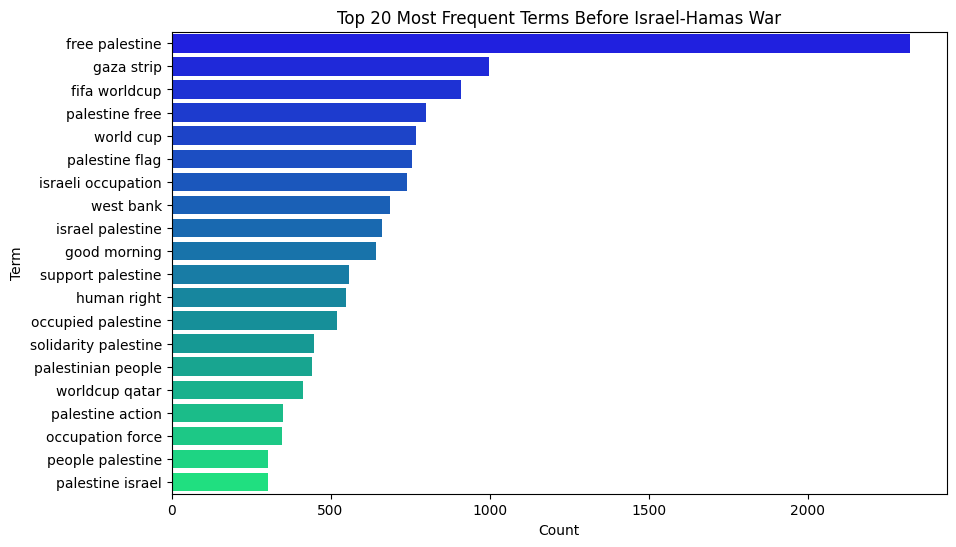

In [11]:
#Most frequent words in before_warv
token_counts_before_war = np.array(twitter_before_tfidf.sum(axis=0))[0]
sorted_indices = np.argsort(token_counts_before_war)[::-1]
vocab_before_war = twitter_before_vect.get_feature_names_out()
term_freq_before_war = [(vocab_before_war[i], token_counts_before_war[i]) for i in sorted_indices]
most_frequent_df = pd.DataFrame(term_freq_before_war, columns=['Term', 'Count'])


plt.figure(figsize=(10, 6))
num_colors = most_frequent_df.head(20).shape[0]
palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, num_colors)])
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20), palette=palette)
plt.title('Top 20 Most Frequent Terms Before Israel-Hamas War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()

/tmp/ipykernel_77367/3104386416.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20), palette=palette)


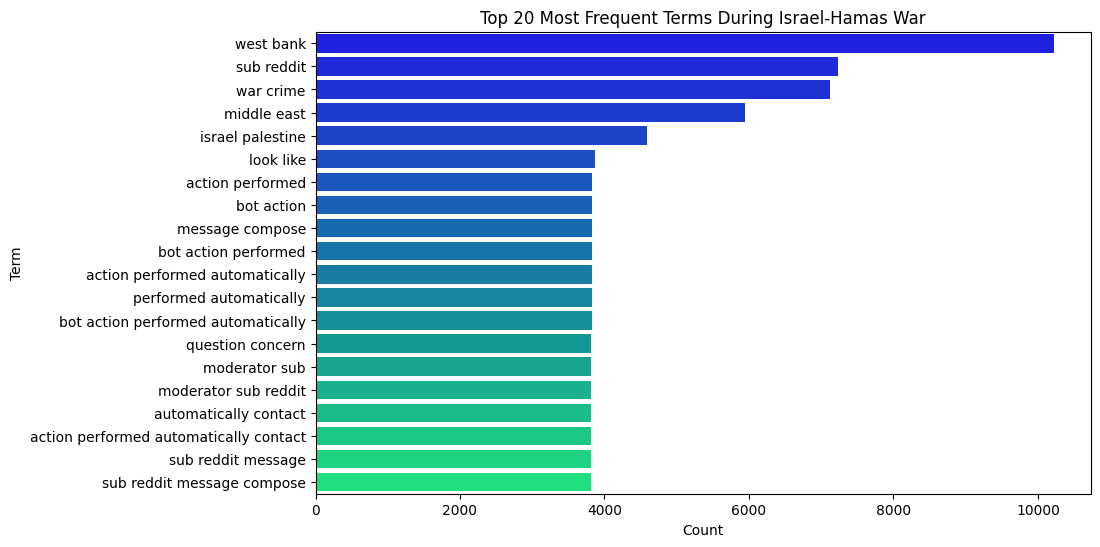

In [13]:
#Most frequent words in after_war
token_counts_war_and_after = np.array(reddit_after_tfidf.sum(axis=0))[0]
sorted_indices = np.argsort(token_counts_war_and_after)[::-1]
vocab_after_war= reddit_after_vect.get_feature_names_out()
term_freq_war_and_after = [(vocab_after_war[i], token_counts_war_and_after[i]) for i in sorted_indices]
most_frequent_df = pd.DataFrame(term_freq_war_and_after, columns=['Term', 'Count'])


# Plot the most frequent terms
plt.figure(figsize=(10, 6))
num_colors = most_frequent_df.head(20).shape[0]
palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, num_colors)])
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20), palette=palette)
plt.title('Top 20 Most Frequent Terms During Israel-Hamas War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()


# LDA Topic Modeling and Visualizaiton

## Twitter Before

In [43]:
from sklearn.decomposition import LatentDirichletAllocation

#seems to be around max_iter 120
twitter_before_lda = LatentDirichletAllocation(n_components=7,
                                   max_iter=120,
                                   learning_method='online',
                                   random_state = 42)

twitter_before_lda.fit(twitter_before_tfidf)

LatentDirichletAllocation(learning_method='online', max_iter=120,
                          n_components=7, random_state=42)

In [44]:
import pyLDAvis.lda_model

#at 10 you have 5 overlapping clusters (topic6+topic7+topic8, topic1+topic2)
vocab_twitter_before = list(twitter_before_vect.get_feature_names_out())
#Read pickled after_war_LDAs
before_vis = pyLDAvis.lda_model.prepare(twitter_before_lda, twitter_before_tfidf, twitter_before_vect, vocab=vocab_twitter_before )
before_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.262346 -0.009051       1        1  19.219268
3      0.251213  0.170395       2        1  15.821412
2      0.017207 -0.263018       3        1  15.349301
5     -0.088028 -0.247551       4        1  13.535867
1     -0.200128  0.190031       5        1  12.650662
6     -0.091143  0.073715       6        1  11.853341
4     -0.151468  0.085479       7        1  11.570148, topic_info=                        Term         Freq        Total Category  logprob  \
1253          free palestine  2158.000000  2158.000000  Default  30.0000   
1435              gaza strip   976.000000   976.000000  Default  29.0000   
1942      israeli occupation   712.000000   712.000000  Default  28.0000   
4767               west bank   672.000000   672.000000  Default  27.0000   
2970          palestine free   742.000000   742.000000  Default  26.0000   
...                      ...          ...          ...      ...      ...   
4916                year ago   150.225524   177.136624   Topic7  -4.4878   
2441             middle east   131.493410   188.659534   Topic7  -4.6210   
2732      occupied palestine   211.455744   499.507713   Topic7  -4.1459   
3450  palestinian resistance    54.340209   102.284207   Topic7  -5.5047   
2706        occupation force    53.575080   330.008677   Topic7  -5.5189   

      loglift  
1253  30.0000  
1435  29.0000  
1942  28.0000  
4767  27.0000  
2970  26.0000  
...       ...  
4916   1.9920  
2441   1.7958  
2732   1.2971  
3450   1.5243  
2706   0.3387  

[267 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
14        2  0.992930               abu leh
59        5  0.989970       aggression gaza
74        6  0.986654            air prison
107       6  0.993778              amp gaza
121       6  0.996266         amp palestine
...     ...       ...                   ...
4916      4  0.146779              year ago
4916      7  0.846804              year ago
4928      7  0.998284              year old
4931      7  0.992017  year old palestinian
4994      7  0.979782        zionist regime

[249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 6, 2, 7, 5])

In [45]:
twitter_before_topic_matrix = twitter_before_lda.fit_transform(twitter_before_tfidf)

## Reddit After

In [89]:
from sklearn.decomposition import LatentDirichletAllocation

#seems to be around max_iter 110
reddit_after_lda= LatentDirichletAllocation(n_components=7,
                                   max_iter=110,
                                   learning_method='online',
                                   random_state = 42)

reddit_after_lda.fit(reddit_after_tfidf)

LatentDirichletAllocation(learning_method='online', max_iter=110,
                          n_components=7, random_state=42)

In [90]:
import pyLDAvis.lda_model

vocab_reddit_after = list(reddit_after_vect.get_feature_names_out())
#Read pickled after_war_LDAs
after_vis = pyLDAvis.lda_model.prepare(reddit_after_lda, reddit_after_tfidf, reddit_after_vect, vocab=vocab_reddit_after )
after_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.294306  0.046682       1        1  19.055615
0      0.251139 -0.138921       2        1  15.751769
6     -0.189433 -0.165030       3        1  15.051084
2     -0.139154  0.231948       4        1  14.496870
3     -0.039976 -0.222917       5        1  12.474888
4     -0.194418 -0.041989       6        1  12.335663
1      0.017536  0.290226       7        1  10.834112, topic_info=                  Term         Freq        Total Category  logprob  loglift
4837         west bank  9451.000000  9451.000000  Default  30.0000  30.0000
4736         war crime  6800.000000  6800.000000  Default  29.0000  29.0000
2853       middle east  5608.000000  5608.000000  Default  28.0000  28.0000
4212        sub reddit  7713.000000  7713.000000  Default  27.0000  27.0000
2682         look like  3763.000000  3763.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
1324      going happen   579.106064   579.968725   Topic7  -5.7081   2.2210
1529        hamas like   554.794589   555.657530   Topic7  -5.7510   2.2209
1426      hamas attack  1046.142765  1549.645704   Topic7  -5.1167   1.8296
2068  israel palestine  1101.172587  4895.204541   Topic7  -5.0655   0.7306
1763      human shield   875.842207  3085.116269   Topic7  -5.2944   0.9633

[253 rows x 6 columns], token_table=      Topic      Freq                                    Term
term                                                         
15        2  0.999255                                act like
25        1  0.999889                        action performed
26        1  0.999755          action performed automatically
27        1  0.999716  action performed automatically contact
68        3  0.999341                              air prison
...     ...       ...                                     ...
4912      2  0.999148                        world news video
4929      5  0.998753                               world war
4953      7  0.999723                                year ago
4963      7  0.999353                                year old
4994      7  0.998842                      zionist propaganda

[227 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 3, 4, 5, 2])

In [47]:
reddit_after_topic_matrix = reddit_after_lda.fit_transform(reddit_after_tfidf)

In [48]:
with open('reddit_after_topic_matrix.pkl', 'wb') as f:
     pickle.dump(reddit_after_topic_matrix, f)

In [313]:
n_top_words = 20
twitter_before_feature_names = twitter_before_vect.get_feature_names_out()

topics = dict()
for topic_idx, topic in enumerate(twitter_before_lda.components_):
    topics[topic_idx] = [twitter_before_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % (topic_idx+1))
    print(" | ".join([twitter_before_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic #1:
fifa worldcup | palestine flag | good morning | support palestine | solidarity palestine | worldcup qatar | people palestine | raise palestine | raise palestine flag | football fan | fifa worldcup qatar | morning palestine | good morning palestine | state palestine | world cup | free palestine | capital palestine | palestine fifa | fan raise | palestine fifa worldcup
Topic #2:
israeli occupation | west bank | occupation force | stand palestine | palestine amp | palestine palestinian | israeli occupation force | occupied west bank | occupied west | ethnic cleansing | bank gaza | west bank gaza | including child | occupied jerusalem | occupied palestine | killed palestinian | israeli settler | palestinian killed | aggression gaza | palestinian including
Topic #3:
free palestine | palestine free | israel palestine | israeli apartheid | palestine free palestine | river sea | palestine israeli | qatar worldcup | sea palestine | apartheid israel | river sea palestine | internationa

# Detoxify library

In [ ]:
pip install detoxify

In [50]:
import detoxify
detox = detoxify.Detoxify('original')

# Get toxicity scores for all ngrams

In [286]:
def create_ngram_tox_dict(ngrams, batch_size=100):
    """Calculate toxicity scores for a list of ngrams in batches."""
    scores = []

    for i in range(0, len(ngrams), batch_size):
        batch = ngrams[i:i+batch_size]
        batch_array = np.array(batch)
        # Convert numpy array to a list
        batch_list = batch_array.tolist()
        results = detox.predict(batch_list)
        scores.extend(results['toxicity'])  # Assuming 'toxicity' is the key of interest

    return scores

# Example usage
before_war_ngrams = twitter_before_vect.get_feature_names_out()
after_war_ngrams = reddit_after_vect.get_feature_names_out()

before_war_tox_scores = create_ngram_tox_dict(before_war_ngrams)
war_and_after_tox_scores = create_ngram_tox_dict(after_war_ngrams)

#map nramgs to scores
twitter_before_ngram_tox_dict = dict(zip(before_war_ngrams, before_war_tox_scores))
reddit_after_ngram_tox_dict = dict(zip(after_war_ngrams, war_and_after_tox_scores))

# Get the cluster avg, max, min, and total tox scores

## Twitter Before

In [292]:
'''
Each doc_vect represents single document's vector in tf-idf matrix (matrix represents corpus for war). Each doc_vect is a row in tf-idf matrix, and each column corresponds to a unique ngram/term across before_war dataset. THe values in doc_vect are tf-idf scores for each ngram in that specific document, and the tf-idf scores represent the importance of an ngram within a documnet (the higher the score, the more relevant to the doc). 
'''
def get_ngram_doc_dict(tf_matrix, feature_names):
    ngram_doc_dict = {} #maps each ngram to the doc it appear in
    #iterate through each doc's vector in tf-idf matrix.
    for doc_idx, doc_vect in enumerate(tf_matrix):
        #find indicies of ngrams whose tfidf_scores !=0.
        ngram_indices = doc_vect.nonzero()[1]  #basically sees which ngrams are present in the document
        for ngram_index in ngram_indices:
            #for non-zero tf-idf scores, it gets corresponding ngram name and maps ngram to current doc (doc_index)
            ngram = feature_names[ngram_index] 
            #if ngram isn't already in ngram_doc_dict, new entry created
            if ngram not in ngram_doc_dict:
                ngram_doc_dict[ngram] = []
            ngram_doc_dict[ngram].append(doc_idx)
    return ngram_doc_dict


In [293]:
'''
Creates dictionary where the keys are topics and the values are list of documents associated with topic
'''
def get_doc_topic_dict(topic_matrix, threshold):
    doc_topic_dict = {}
    for doc_idx, topic_dist in enumerate(topic_matrix):
        topic = np.argmax(topic_dist) #get index of 
        if topic_dist[topic] >= threshold:
            if topic not in doc_topic_dict:
                doc_topic_dict[topic] = []
            doc_topic_dict[topic].append(doc_idx)
    return doc_topic_dict



In [294]:
'''
Gets dictionary where key = topic_index, and values are ngrams in each topic
'''
# def get_topic_ngram_dict(doc_topic_dict, ngram_doc_dict):
#     topic_ngrams_dict = {} #will store top_idx: [ngrams in topic]

#     #iterate over each doc associated with a given topic
#     for topic_idx, doc_IDs in doc_topic_dict.items():
#         topic_ngrams = set()
#         #loop through each doc in the list of doc_IDs that are linked with current topic
#         for doc in doc_IDs:
#             #check each ngram to see if the current doc is one of the docs containing given ngram
#             for ngram, doc_indices in ngram_doc_dict.items():
#                 #if ngram is present in current doc
#                 if doc in doc_indices:
#                     topic_ngrams.add(ngram) #if so, add ngram to topic's value list
#         #update dict
#         topic_ngrams_dict[topic_idx] = topic_ngrams
#     return topic_ngrams_dict


def get_topic_ngram_dict(doc_topic_dict, ngram_doc_dict):
    # Invert ngram_doc_dict to doc_ngram_dict
    doc_ngram_dict = {}
    for ngram, docs in ngram_doc_dict.items():
        for doc in docs:
            if doc not in doc_ngram_dict:
                doc_ngram_dict[doc] = set()
            doc_ngram_dict[doc].add(ngram)

    # Now create the topic_ngrams_dict using set unions
    topic_ngrams_dict = {}
    for topic_idx, doc_IDs in doc_topic_dict.items():
        topic_ngrams = set()
        for doc in doc_IDs:
            if doc in doc_ngram_dict:
                topic_ngrams.update(doc_ngram_dict[doc])  # Use set update for union operation
        topic_ngrams_dict[topic_idx] = topic_ngrams

    return topic_ngrams_dict


In [295]:
twitter_before_feature_names = twitter_before_vect.get_feature_names_out()  
twitter_before_ngram_doc_dict = get_ngram_doc_dict(twitter_before_tfidf, twitter_before_feature_names)
twitter_before_doc_topic_dict = get_doc_topic_dict(twitter_before_topic_matrix, 0.7)
twitter_before_topic_ngram_dict= get_topic_ngram_dict(twitter_before_doc_topic_dict, twitter_before_ngram_doc_dict)

In [297]:
'''
Calculate min, max, average, and total toxicity scores for ngrams in each topic. Accepts the topic_ngrams_dict (dict mapping topics to ngrams contained in each topic) and ngram_tox_dict (dict mapping ngrams to their toxicity scores). Returns a dictionary where topic index are the keys and toxicity stats are values.
'''

def calculate_toxicity_stats(topic_ngrams_dict, ngram_toxicity_scores):
    topic_toxicity_stats = {}
    for topic, ngrams in topic_ngrams_dict.items():
        #filter out n-grams that don't have associated toxicity scores
        filtered_scores = [ngram_toxicity_scores[ngram] for ngram in ngrams if ngram in ngram_toxicity_scores]
        
        if filtered_scores:
            min_score = min(filtered_scores)
            max_score = max(filtered_scores)
            avg_score = sum(filtered_scores) / len(filtered_scores)
            total_score = sum(filtered_scores)
        else:
            #will set default values if no scores found
            min_score, max_score, avg_score, total_score = float('inf'), float('-inf'), 0, 0
        
        topic_toxicity_stats[topic] = {
            'min_toxicity': min_score,
            'max_toxicity': max_score,
            'average_toxicity': avg_score,
            'total_toxicity': total_score,
            'ngram_count': len(filtered_scores) 
        }
        
    return topic_toxicity_stats

In [298]:
twitter_before_topic_stats = calculate_toxicity_stats(twitter_before_topic_ngram_dict, twitter_before_ngram_tox_dict)
twitter_before_topic_stats = collections.OrderedDict(sorted(twitter_before_topic_stats.items()))
twitter_before_topic_stats

OrderedDict([(0,
              {'min_toxicity': 0.0003435748803894967,
               'max_toxicity': 0.6188274025917053,
               'average_toxicity': 0.021600296969450757,
               'total_toxicity': 22.939515381556703,
               'ngram_count': 1062}),
             (1,
              {'min_toxicity': 0.00034844293259084225,
               'max_toxicity': 0.8632962107658386,
               'average_toxicity': 0.060715831331753865,
               'total_toxicity': 36.975941281038104,
               'ngram_count': 609}),
             (2,
              {'min_toxicity': 0.0003651855804491788,
               'max_toxicity': 0.9565209150314331,
               'average_toxicity': 0.03937996100369624,
               'total_toxicity': 28.471711805672385,
               'ngram_count': 723}),
             (3,
              {'min_toxicity': 0.00036555950646288693,
               'max_toxicity': 0.9058831334114075,
               'average_toxicity': 0.03184077063465439,
             

In [38]:
with open('reddit_after_vect.pkl','rb') as f:
    reddit_after_vect = pickle.load(f)

with open('reddit_after_tfidf.pkl','rb') as f:
    reddit_after_tfidf = pickle.load(f)

with open('reddit_after_topic_matrix.pkl','rb') as f:
    reddit_after_topic_matrix = pickle.load(f)

with open('reddit_after_ngram_doc_dict.pkl','rb') as f:
    reddit_after_ngram_doc_dict = pickle.load(f)

    
with open('reddit_after_ngram_tox_dict.pkl','rb') as f:
    reddit_after_ngram_tox_dict = pickle.load(f)
    
with open('reddit_after_doc_topic_dict.pkl','rb') as f:
    reddit_after_doc_topic_dict = pickle.load(f)
    
with open('reddit_after_topic_ngrams_dict.pkl', 'rb') as f:
    reddit_after_topic_ngrams_dict = pickle.load(f)

    
with open('twitter_before_topic_stats.pkl', 'rb') as f:
    twitter_before_topic_stats = pickle.load(f)


/home/mrtcloud-8/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Reddit After

In [299]:
feature_names = reddit_after_vect.get_feature_names_out()  # Ensure this line correctly defines 
reddit_after_ngram_doc_dict = get_ngram_doc_dict(reddit_after_tfidf, feature_names)
reddit_after_doc_topic_dict = get_doc_topic_dict(reddit_after_topic_matrix, 0.7)
reddit_after_topic_ngrams_dict = get_topic_ngram_dict(reddit_after_doc_topic_dict, reddit_after_ngram_doc_dict)

In [61]:
reddit_after_topic_stats = calculate_toxicity_stats(reddit_after_topic_ngrams_dict, reddit_after_ngram_tox_dict)
reddit_after_topic_stats = collections.OrderedDict(sorted(reddit_after_topic_stats.items()))
reddit_after_topic_stats


In [301]:
with open('UNBIASED_reddit_after_ngram_doc_dict.pkl', 'wb') as f:
     pickle.dump(reddit_after_ngram_doc_dict, f)
    
with open('UNBIASED_reddit_after_doc_topic_dict.pkl', 'wb') as f:
     pickle.dump(reddit_after_doc_topic_dict, f)

with open('UNBIASED_reddit_after_topic_ngrams_dict.pkl', 'wb') as f:
     pickle.dump(reddit_after_topic_ngrams_dict, f)
    
with open('UNBIASED_reddit_after_topic_stats.pkl', 'wb') as f:
     pickle.dump(reddit_after_topic_stats, f)




/tmp/ipykernel_184272/3647650872.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')


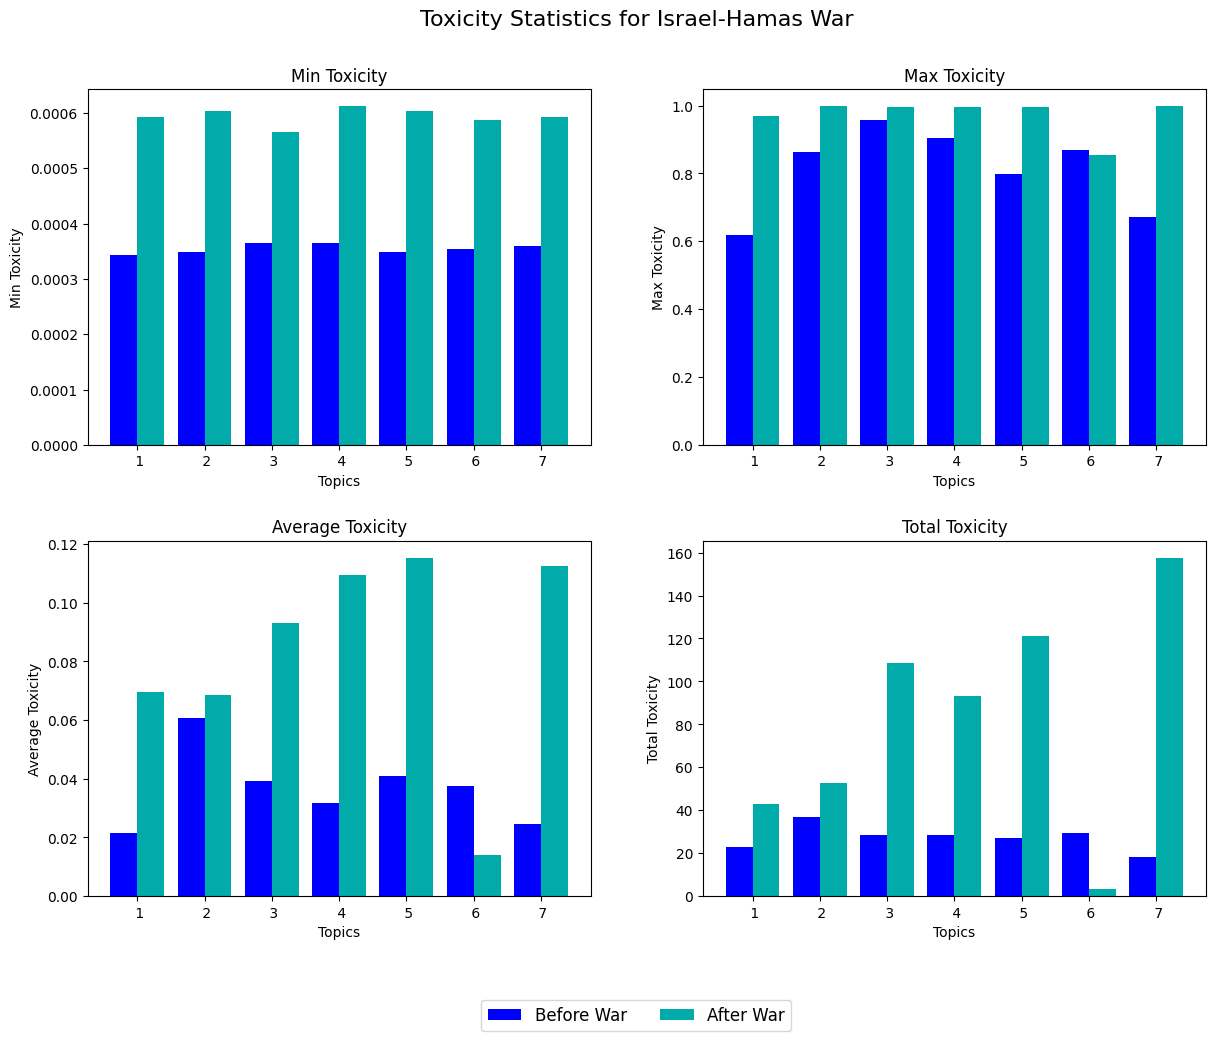

In [337]:
# fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

# Adjust layout for better spacing
fig.tight_layout(pad=5.0)
fig.subplots_adjust(top=0.9)

# Titles for each subplot
titles = ['Min Toxicity', 'Max Toxicity', 'Average Toxicity', 'Total Toxicity']
metrics = ['min_toxicity', 'max_toxicity', 'average_toxicity', 'total_toxicity']
main_title = 'Toxicity Statistics for Israel-Hamas War'

offset = 0.1  # Space between the groups of bars
cmap = get_cmap('winter')
colors = [cmap(0.0), cmap(0.45), cmap(0.67), cmap(0.80), cmap(1.0)]

fig.suptitle(main_title, fontsize=16)


for i, metric in enumerate(metrics):
    #current row and column indices for the sub
    row = i // 2
    col = i % 2
    
    # Extract data for the current metric from both periods
    twitter_before_values = [twitter_before_topic_stats[topic][metric] for topic in sorted(twitter_before_topic_stats.keys())]
    reddit_after_values = [reddit_after_topic_stats[topic][metric] for topic in sorted(reddit_after_topic_stats.keys())]
    
    topics = range(len(twitter_before_values))
    width = 0.4
    
    #create bar plots
    bars_before = axs[row, col].bar([x - width/2 for x in topics], twitter_before_values, width, label='Before War', color = colors[0])
    bars_after = axs[row, col].bar([x + width/2 for x in topics], reddit_after_values, width, label='After War', color=colors[2])

    #add data labels
    # for bars in [bars_before, bars_after]:
    #     for bar in bars:
    #         yval = bar.get_height()
    #         axs[row, col].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    #titles for subplots
    axs[row, col].set_title(titles[i])
    axs[row, col].set_xlabel('Topics')
    axs[row, col].set_ylabel(metric.title().replace('_', ' '))
    
    #center  x-ticks 
    axs[row, col].set_xticks(topics)
    new_labels = [f' {i+1}' for i in topics]
    axs[row, col].set_xticklabels(new_labels)
# axs[row, col].legend(loc='upper left', bbox_to_anchor=(1.05, 2))
fig.legend(['Before War', 'After War'], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize='large')

# Display the plot
plt.show()

# Linear Regression

In [148]:
''''
Function calculates the document-level toxicity score for each document. This is done by taking into account the tf-idf representation of the documents, the dictionary mapping ngrams to toxicity scores, and the names of the features as extracted by the tf-idf vectorizer. 

It uses the pre-existing TF-IDF matrix (before_war_tfidf and war_and_after_tfidf matrix) and the feature names to identify the ngrams in each document and their TF-IDF score. 

Overall it assess the weighted average toxicity of each document by considering both the presence and importance (as indicated by the TF-IDF tmatrix) of toxic ngrams within each document. 
'''
def calculate_doc_level_toxicity(tfidf_matrix, feature_names, ngram_toxicity_dict):

    doc_toxicity_scores = [] #stores avgs for each doc

    #convert tfidf matrix to dense format so we can carry out operations on individual elements. 
    #https://en.ittrip.xyz/python/python-matrix-operations    ngram_present_mat = tfidf_matrix.sign().todense()
    ngram_present_mat = tfidf_matrix.sign().todense()
    
    for doc_idx in range(ngram_present_mat.shape[0]):
        doc_score_list = []  # Will store toxicity scores for the document

        #for each feature
        for feat_idx in range(ngram_present_mat.shape[1]):
            feature = feature_names[feat_idx]
            #checkif ngram is present in doc and has tox_score. If so, append doc_score to list
            if ngram_present_mat[doc_idx, feat_idx] > 0 and feature in ngram_toxicity_dict:
                toxicity_score = ngram_toxicity_dict[feature]
                doc_score_list.append(toxicity_score)

        #calculate the average toxicity score for the document
        if doc_score_list:
            avg_doc_toxicity = np.mean(doc_score_list)
        else:
            # If no ngrams in the document have known toxicity scores
            avg_doc_toxicity = 0

        #store the calculated average toxicity for the document
        doc_toxicity_scores.append(avg_doc_toxicity)

    return np.array(doc_toxicity_scores)
twitter_before_feature_names = twitter_before_vect.get_feature_names_out()
# before_war_doc_toxicity_scores = calculate_doc_level_toxicity(before_war_tfidf, before_war_feature_names, before_war_ngram_tox_dict)

twitter_before_doc_toxicity_scores = calculate_doc_level_toxicity(twitter_before_tfidf, twitter_before_feature_names, twitter_before_ngram_tox_dict)

reddit_after_doc_toxicity_scores = calculate_doc_level_toxicity(reddit_after_tfidf, reddit_after_feature_names, reddit_after_ngram_tox_dict)

In [358]:
with open('twitter_before_cleaned.pkl', 'rb') as f:
    twitter_before = pickle.load(f)
with open('reddit_after_cleaned.pkl', 'rb') as f:
    reddit_after = pickle.load(f)

with open('twitter_before_vect.pkl', 'rb') as f:
    twitter_before_vect = pickle.load(f)
with open('reddit_after_vect.pkl', 'rb') as f:
    reddit_after_vect = pickle.load(f)


with open('twitter_before_tfidf.pkl', 'rb') as f:
    twitter_before_tfidf = pickle.load(f)
with open('reddit_after_tfidf.pkl', 'rb') as f:
    reddit_after_tfidf = pickle.load(f)

with open('UNBIASED_twitter_before_ngram_tox_dict.pkl', 'rb') as f:
    twitter_before_ngram_tox_dict = pickle.load(f)
with open('UNBIASED_reddit_after_ngram_tox_dict.pkl', 'rb') as f:
    reddit_after_ngram_tox_dict = pickle.load(f)


with open('twitter_before_topic_matrix.pkl', 'rb') as f:
    twitter_before_topic_matrix = pickle.load(f)



with open('UNBIASED_twitter_before_doc_toxicity_scores.pkl', 'rb') as f:
    twitter_before_doc_toxicity_scores = pickle.load(f)
    
with open('UNBIASED_reddit_after_doc_toxicity_scores.pkl', 'rb') as f:
    reddit_after_doc_toxicity_scores = pickle.load(f)


with open('twitter_before_lda.pkl', 'rb') as f:
    twitter_before_lda = pickle.load(f)
with open('reddit_after_lda.pkl', 'rb') as f:
    reddit_after_lda = pickle.load(f)

/home/mrtcloud-8/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [355]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler


# x_train = twitter_before_tfidf
# y_train = twitter_before_doc_toxicity_scores

# model = LinearRegression()
# model.fit(x_train, y_train)

# x_test = reddit_after_tfidf
# predicted_tox_scores = model.predict(x_test)



x_train = twitter_before_tfidf
y_train = twitter_before_doc_toxicity_scores
x_test = reddit_after_tfidf

scaler = MaxAbsScaler()
# scaler = RobustScaler(with_centering = False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

model = LinearRegression()
model.fit(x_train, y_train)

predicted_tox_scores = model.predict(x_test)


In [289]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#calc evalution metrics
mse = mean_squared_error(reddit_after_doc_toxicity_scores, predicted_tox_scores)
mae = mean_absolute_error(reddit_after_doc_toxicity_scores, predicted_tox_scores)
r2 = r2_score(reddit_after_doc_toxicity_scores, predicted_tox_scores)

#print
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.012007795256333272
Mean Absolute Error (MAE): 0.04612349010886901
R-squared (R2): -0.19386219623635137


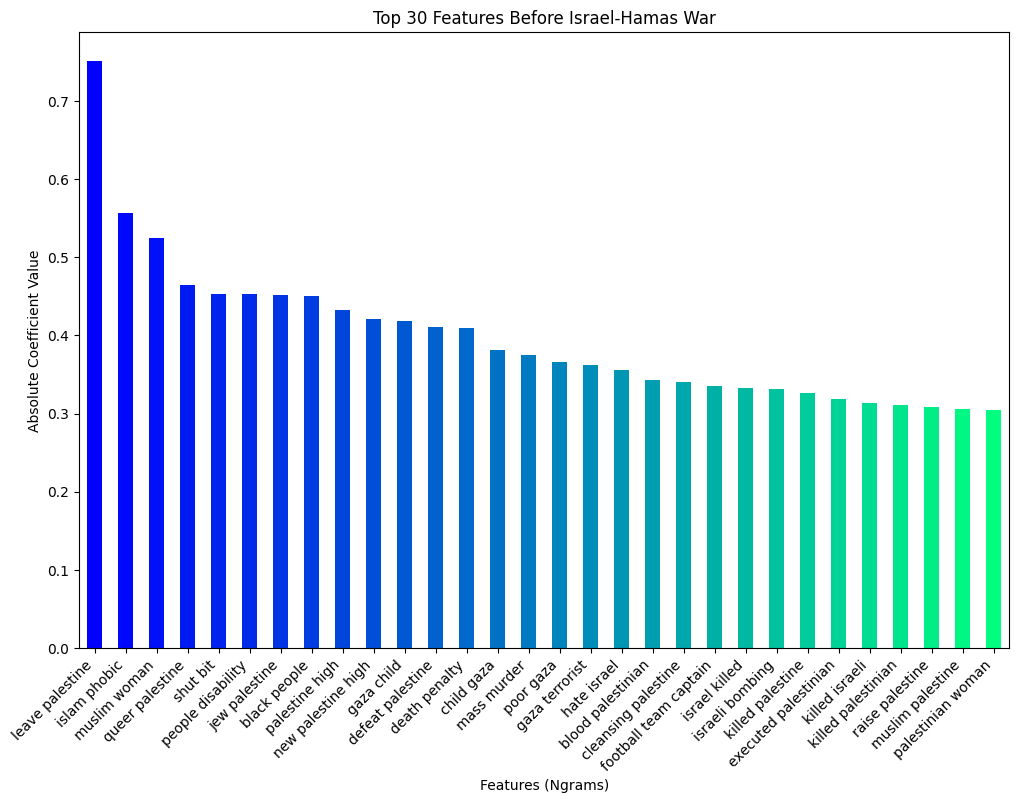

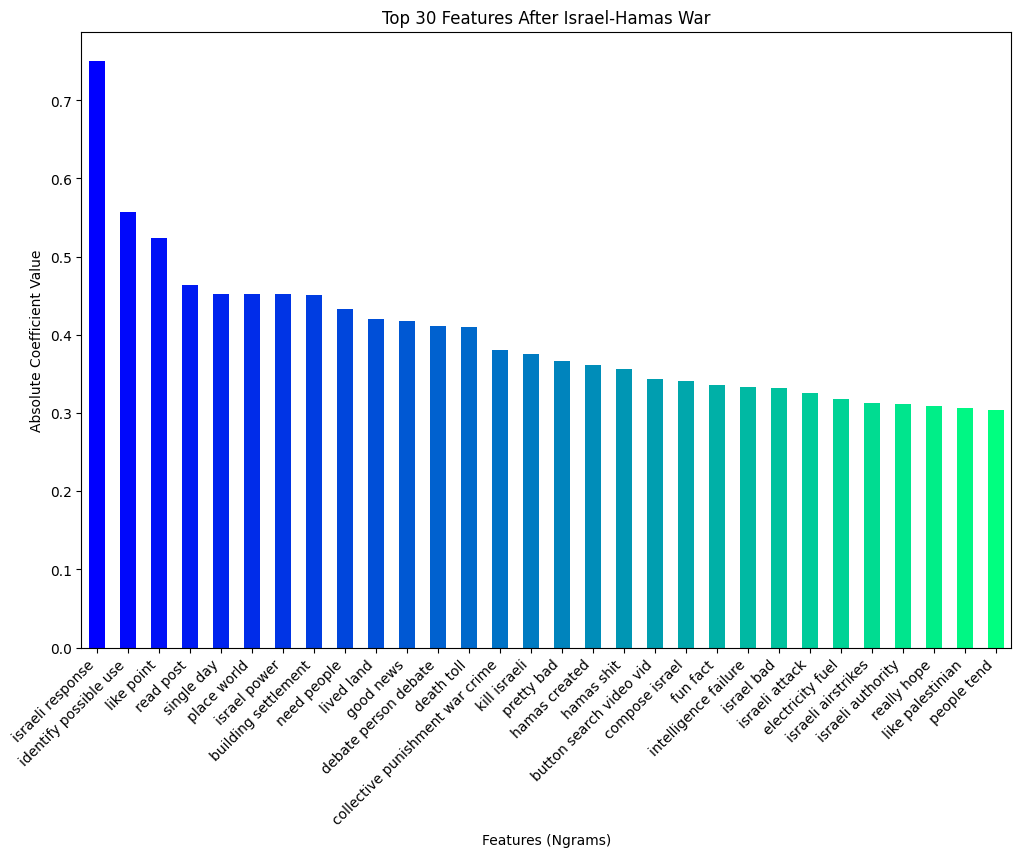

In [189]:
import matplotlib.pyplot as plt
twitter_before_feature_names = twitter_before_vect.get_feature_names_out()

num_colors = len(sorted_features)
palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, num_colors)])
coefficients = model.coef_
feature_importance = pd.Series(coefficients, index=twitter_before_feature_names)

# Sort the features by absolute value of their coefficient
sorted_features = feature_importance.abs().sort_values(ascending=False).head(30)

plt.figure(figsize=(12, 8))
sorted_features.plot(kind='bar', color = palette) 
plt.title('Top 30 Features Before Israel-Hamas War')
plt.ylabel('Absolute Coefficient Value')
plt.xlabel('Features (Ngrams)')
plt.xticks(rotation=45, ha='right')
plt.show()



reddit_after_feature_names = reddit_after_vect.get_feature_names_out()
coefficients = model.coef_
feature_importance = pd.Series(coefficients, index=reddit_after_feature_names)
# Sort the features by absolute value of their coefficient
sorted_features = feature_importance.abs().sort_values(ascending=False).head(30)
# Plot
plt.figure(figsize=(12, 8))
sorted_features.plot(kind='bar', color=palette)
plt.title('Top 30 Features After Israel-Hamas War')
plt.ylabel('Absolute Coefficient Value')
plt.xlabel('Features (Ngrams)')
plt.xticks(rotation=45, ha='right')
plt.show()


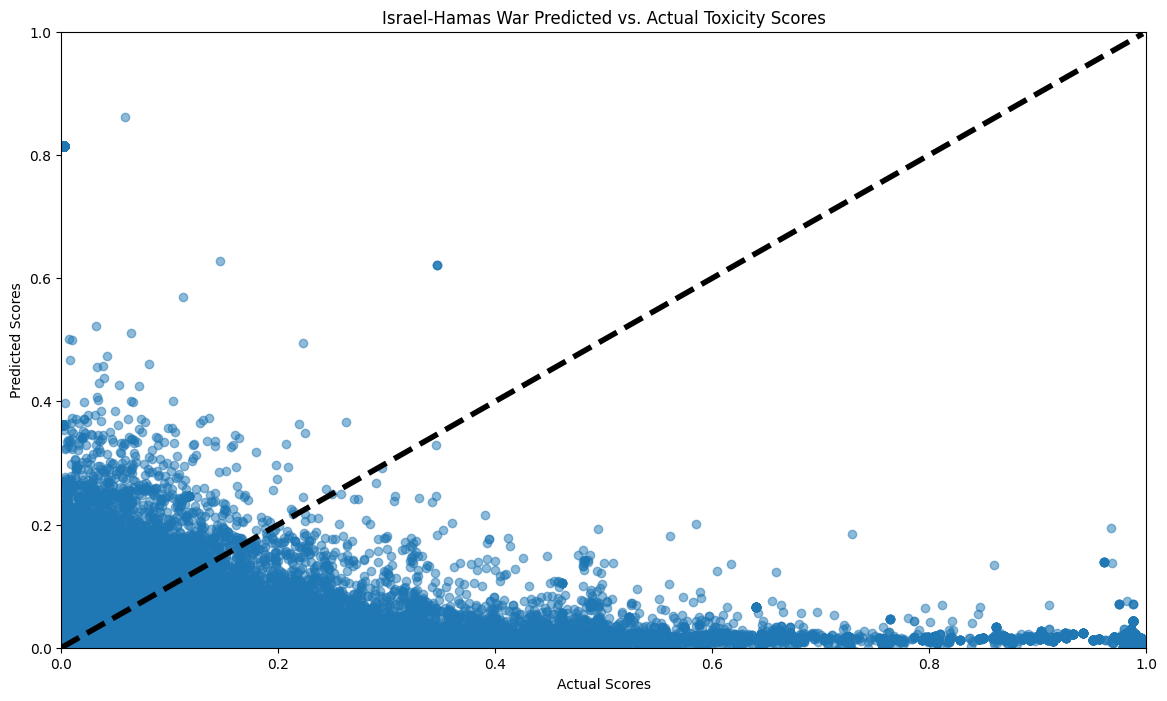

In [338]:
#take 

# plt.figure(figsize=(10, 8))
plt.figure(figsize=(14, 8))

plt.scatter(reddit_after_doc_toxicity_scores, predicted_tox_scores, alpha=0.5)
plt.title('Israel-Hamas War Predicted vs. Actual Toxicity Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.plot([reddit_after_doc_toxicity_scores.min(), reddit_after_doc_toxicity_scores.max()], [reddit_after_doc_toxicity_scores.min(), reddit_after_doc_toxicity_scores.max()], 'k--', lw=4)
plt.show()

#line of best fit

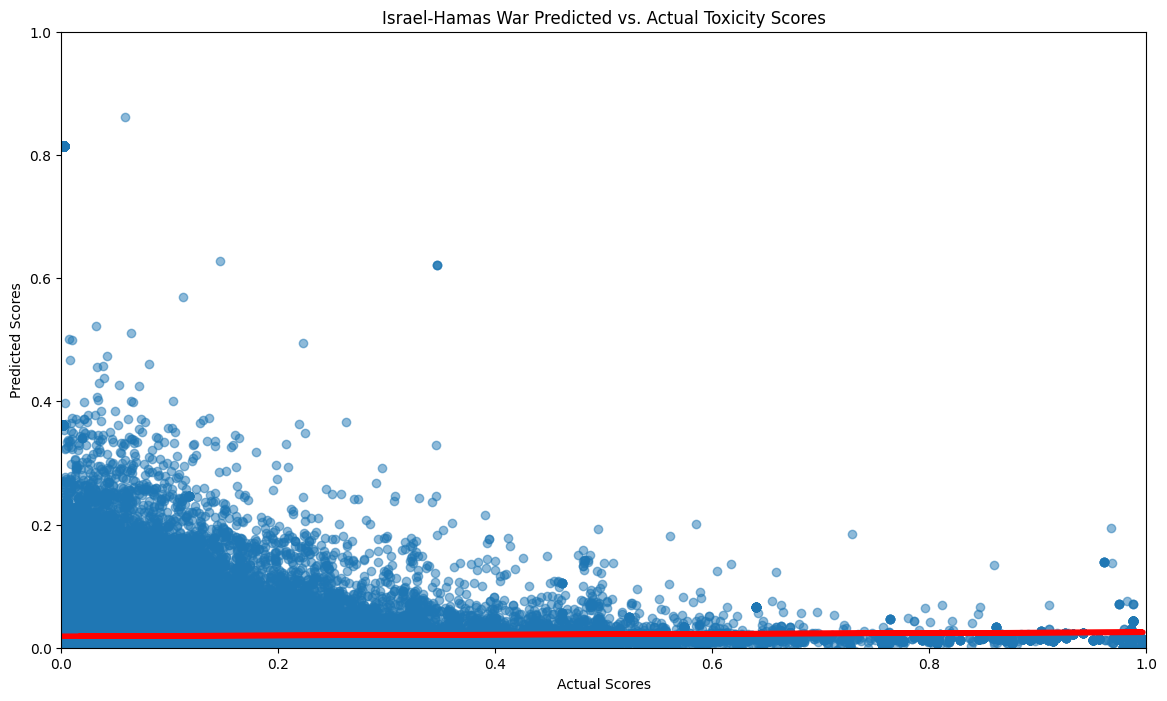

In [362]:
import numpy as np
import matplotlib.pyplot as plt


# Create the plot
plt.figure(figsize=(14, 8))
plt.scatter(reddit_after_doc_toxicity_scores, predicted_tox_scores, alpha=0.5)
plt.title('Israel-Hamas War Predicted vs. Actual Toxicity Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.ylim(0, 1)
plt.xlim(0, 1)

# Calculate the line of best fit
slope, intercept = np.polyfit(reddit_after_doc_toxicity_scores, predicted_tox_scores, 1)
line = slope * reddit_after_doc_toxicity_scores + intercept

# Plot the line of best fit
plt.plot(reddit_after_doc_toxicity_scores, line, 'r-', linewidth=4)  # 'r-' makes the line red
# plt.plot([reddit_after_doc_toxicity_scores.min(), reddit_after_doc_toxicity_scores.max()], [reddit_after_doc_toxicity_scores.min(), reddit_after_doc_toxicity_scores.max()], 'k--', lw=4)

plt.show()


In [357]:
print(len(predicted_tox_scores))
print(len(reddit_after_doc_toxicity_scores))

436718
5


# Get Accuracy

In [303]:
actual_scores = reddit_after_doc_toxicity_scores
pred_scores = predicted_tox_scores

actual_scores_df= pd.DataFrame(actual_scores)
predicted_scores_df = pd.DataFrame(pred_scores)
scores_diff = np.abs(actual_scores - pred_scores)


#Threshold option 1: avg difference in score

median_thres =  np.median(scores_diff)
print("median as threshold: ", median_thres)
corr_pred = np.sum(scores_diff <= median_thres)
acc_median = corr_pred / len(scores_diff)
print("accuracy for difference: ", acc_median, "\n")

avg_thres =  np.mean(scores_diff)
print("avg as threshold: ", avg_thres)
corr1_pred = np.sum(scores_diff <= avg_thres)
acc_avg = corr1_pred / len(scores_diff)
print("accuracy for difference: ", acc_avg, "\n")

std_thres =  np.std(scores_diff)
print("standard deviation as threshold: ", std_thres)
corr2_pred = np.sum(scores_diff <= std_thres)
acc_std = corr2_pred / len(scores_diff)
print("accuracy for difference: ", acc_std, "\n")

std_avg_thres =  np.std(scores_diff) + np.mean(scores_diff)
print("std_deviation + mean threshold: ", std_avg_thres)
corr3_pred = np.sum(scores_diff <= std_avg_thres)
acc_std_avg = corr3_pred / len(scores_diff)
print("accuracy for difference ", acc_std_avg, "\n")

max_thres =  np.max(scores_diff) * 0.1
print("10% of max as threshold: ", max_thres)
corr4_pred = np.sum(scores_diff <= max_thres)
acc_max = corr4_pred / len(scores_diff)
print("accuracy for difference: ", acc_max, "\n")

quartiles = np.percentile(scores_diff, [25, 50, 75])
first_quartile = quartiles[0]
median = quartiles[1]
third_quartile = quartiles[2]
iqr_thres = third_quartile - first_quartile
print("IQR threshold: ", iqr_thres)
corr_pred5 = np.sum(scores_diff <= iqr_thres)
acc_iqr = corr_pred5 / len(scores_diff)
print("accuracy for difference: ", acc_iqr, "\n")

median as threshold:  0.015888473101832966
accuracy for difference:  0.645496636273293 

avg as threshold:  0.04612349010886901
accuracy for difference:  0.8157369286358703 

standard deviation as threshold:  0.09940029636027417
accuracy for difference:  0.8963015034873762 

std_deviation + mean threshold:  0.14552378646914318
accuracy for difference  0.9285465678080592 

10% of max as threshold:  0.10045427283551477
accuracy for difference:  0.8971716302053041 

IQR threshold:  0.011676310710636913
accuracy for difference:  0.15860578222102134 



[(0.011676310710636913, 0.15860578222102134), (0.015888473101832966, 0.645496636273293), (0.04612349010886901, 0.8157369286358703), (0.09940029636027417, 0.8963015034873762), (0.10045427283551477, 0.8971716302053041), (0.14552378646914318, 0.9285465678080592)]
thresholds:
(0.011676310710636913, 0.015888473101832966, 0.04612349010886901, 0.09940029636027417, 0.10045427283551477, 0.14552378646914318)





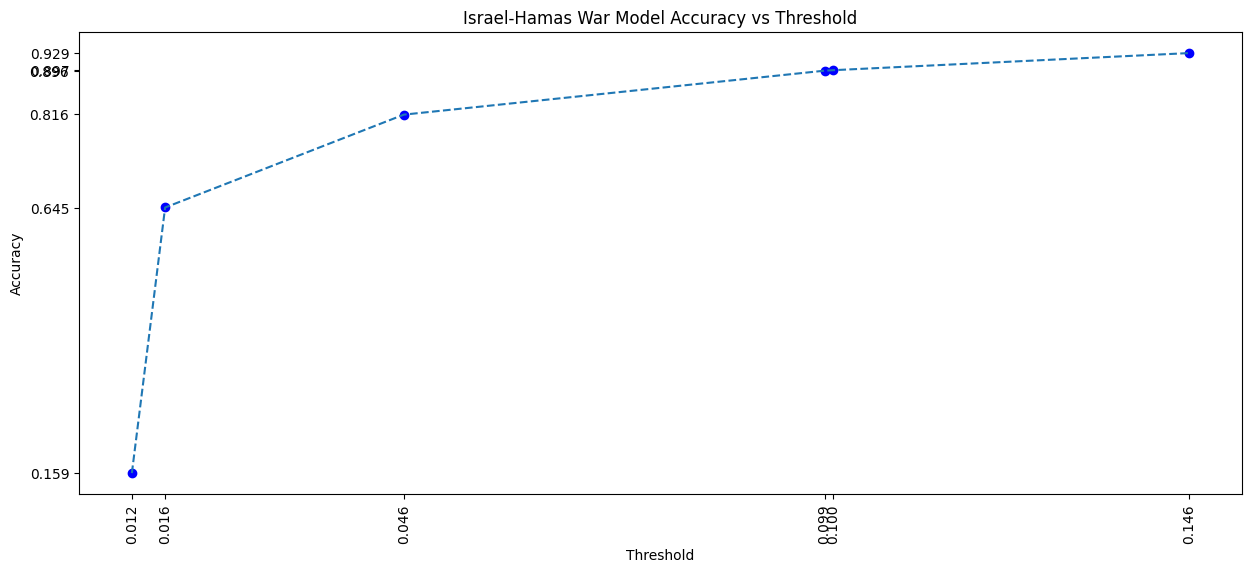

In [365]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
#sort by threshold and accuracy values
thresholds = [median_thres, avg_thres, std_thres, std_avg_thres, max_thres, iqr_thres]
# thresholds = [median_thres, avg_thres, std_thres, std_avg_thres, iqr_thres]

accuracies = [acc_median, acc_avg, acc_std, acc_std_avg, acc_max, acc_iqr]
#accuracies = [acc_median, acc_avg, acc_std, acc_std_avg, acc_iqr]

pairs = list(zip(thresholds, accuracies))
sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=False)
print(sorted_pairs)

# sorted_accuracies = list(sorted_accuracies)
# sorted_thresholds = list(sorted_thresholds)
sorted_thresholds, sorted_accuracies = zip(*sorted_pairs)
print("thresholds:")
print(sorted_thresholds)
print("\n\n")

plt.scatter(sorted_thresholds, sorted_accuracies, color='blue')
plt.plot(sorted_thresholds, sorted_accuracies,linestyle='--')


# Add titles and labels
plt.title('Israel-Hamas War Model Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')


plt.xticks(sorted_thresholds, [f'{t:.3f}' for t in sorted_thresholds])
plt.xticks(rotation =90)  # Rotate labels and align right
plt.yticks([round(a, 3) for a in sorted_accuracies])

#Remove Grid
plt.grid(False)

# Show the plot
plt.show()

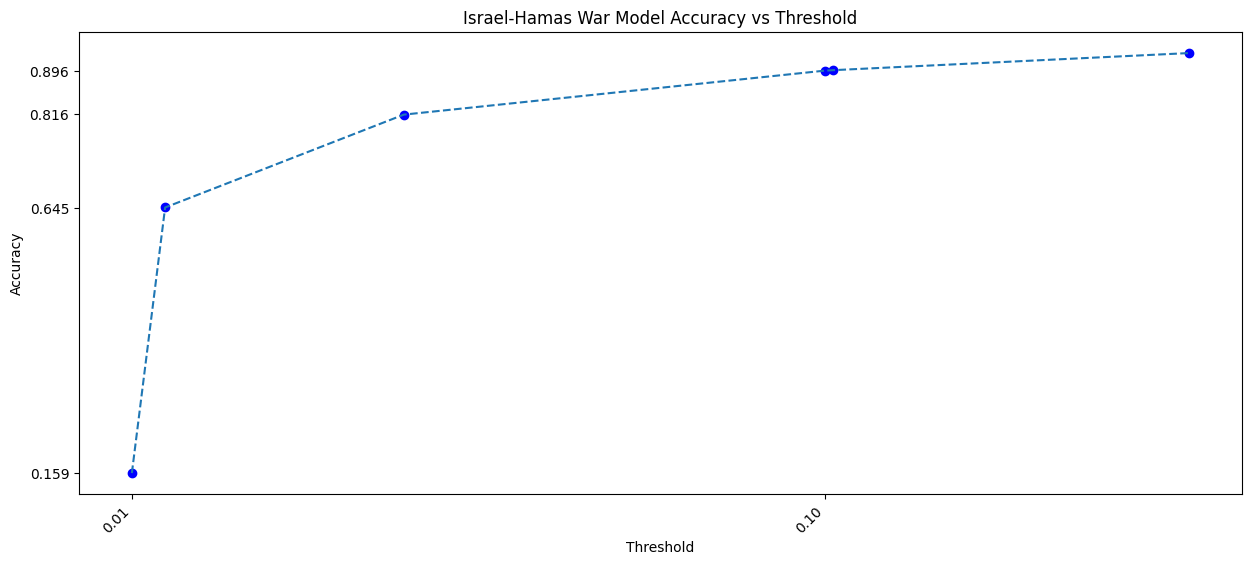

In [379]:
import numpy as np
import matplotlib.pyplot as plt

def filter_ticks(ticks, threshold=0.05):
    # This function filters out ticks that are too close to each other
    filtered_ticks = [ticks[0]]  # Always include the first tick
    for tick in ticks[1:]:
        if tick - filtered_ticks[-1] > threshold:
            filtered_ticks.append(tick)
    return filtered_ticks

plt.figure(figsize=(15,6))

thresholds = [median_thres, avg_thres, std_thres, std_avg_thres, max_thres, iqr_thres]
accuracies = [acc_median, acc_avg, acc_std, acc_std_avg, acc_max, acc_iqr]

pairs = sorted(zip(thresholds, accuracies), key=lambda x: x[0])  # Sort by threshold
sorted_thresholds, sorted_accuracies = zip(*pairs)

# Filter the thresholds for plotting
filtered_thresholds = filter_ticks(sorted_thresholds)
filtered_accuracies = filter_ticks(sorted_accuracies)


plt.scatter(sorted_thresholds, sorted_accuracies, color='blue')
plt.plot(sorted_thresholds, sorted_accuracies, linestyle='--')

plt.title('Israel-Hamas War Model Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(filtered_thresholds, [f'{t:.2f}' for t in filtered_thresholds], rotation=45, ha='right')
plt.yticks([round(a, 3) for a in filtered_accuracies])

plt.show()


# Visualize Topic MSE, MAE and R2

In [191]:

with open('reddit_after_doc_topic_dict.pkl', 'rb') as f:
    reddit_after_doc_topic_dict = pickle.load(f)


with open('twitter_before_doc_toxicity_scores.pkl', 'rb') as f:
    twitter_before_doc_toxicity_scores = pickle.load(f)
    
with open('reddit_after_doc_toxicity_scores.pkl', 'rb') as f:
    reddit_after_doc_toxicity_scores = pickle.load(f)
    

In [195]:
actual_topic_scores = reddit_after_doc_toxicity_scores
actual_topic_scores

array([0.        , 0.98667288, 0.11580674, ..., 0.        , 0.        ,
       0.01121919])

In [198]:

#dictionary to store mse, mae and r2
topic_regression_metrics = {}

#for each topic and its associated documents
for topic_idx, documents in reddit_after_doc_topic_dict.items():
    #extract the actual and predicted scores
    actual_topic_scores = reddit_after_doc_toxicity_scores[documents]
    predicted_topic_scores = predicted_tox_scores[documents]
        
    #calculate the mse, mae and r2
    mse = mean_squared_error(actual_topic_scores, predicted_topic_scores)
    mae = mean_absolute_error(actual_topic_scores, predicted_topic_scores)
    r2 = r2_score(actual_topic_scores, predicted_topic_scores)

    topic_regression_metrics[topic_idx] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
    }

topic_regression_metrics

#convert from dict to data frame
metric_data = []
for topic, reg_metrics in topic_regression_metrics.items():
    metric_data.append({
        'Topic': topic,
        'MSE': reg_metrics['MSE'],
        'MAE': reg_metrics['MAE'],
        'R2': reg_metrics['R2']
    })
    
topic_regression_metrics_df = pd.DataFrame(metric_data)
topic_regression_metrics_df =  topic_regression_metrics_df.melt(id_vars=['Topic'], value_vars=['MSE', 'MAE', 'R2'], var_name='Metric', value_name='Value')
topic_regression_metrics = collections.OrderedDict(sorted(topic_regression_metrics.items()))
topic_regression_metrics

OrderedDict([(0,
              {'MSE': 0.0994752826219415,
               'MAE': 0.24348812548521734,
               'R2': -5.017070207486548}),
             (1,
              {'MSE': 0.02604861301274574,
               'MAE': 0.10255134509912045,
               'R2': -0.5217836357260281}),
             (2,
              {'MSE': 0.4046888234299053,
               'MAE': 0.25229391280001134,
               'R2': -12.524898185598776}),
             (3,
              {'MSE': 0.02859410557924863,
               'MAE': 0.09566868955180671,
               'R2': -0.12167734991325263}),
             (4,
              {'MSE': 0.04866284171671663,
               'MAE': 0.12011865758146725,
               'R2': -0.141685244214784}),
             (5,
              {'MSE': 0.03580024386744864,
               'MAE': 0.15603438542653844,
               'R2': -2806.774442914045}),
             (6,
              {'MSE': 0.03756714761875377,
               'MAE': 0.11276407149335338,
               'R2'

/tmp/ipykernel_184272/2711686957.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')


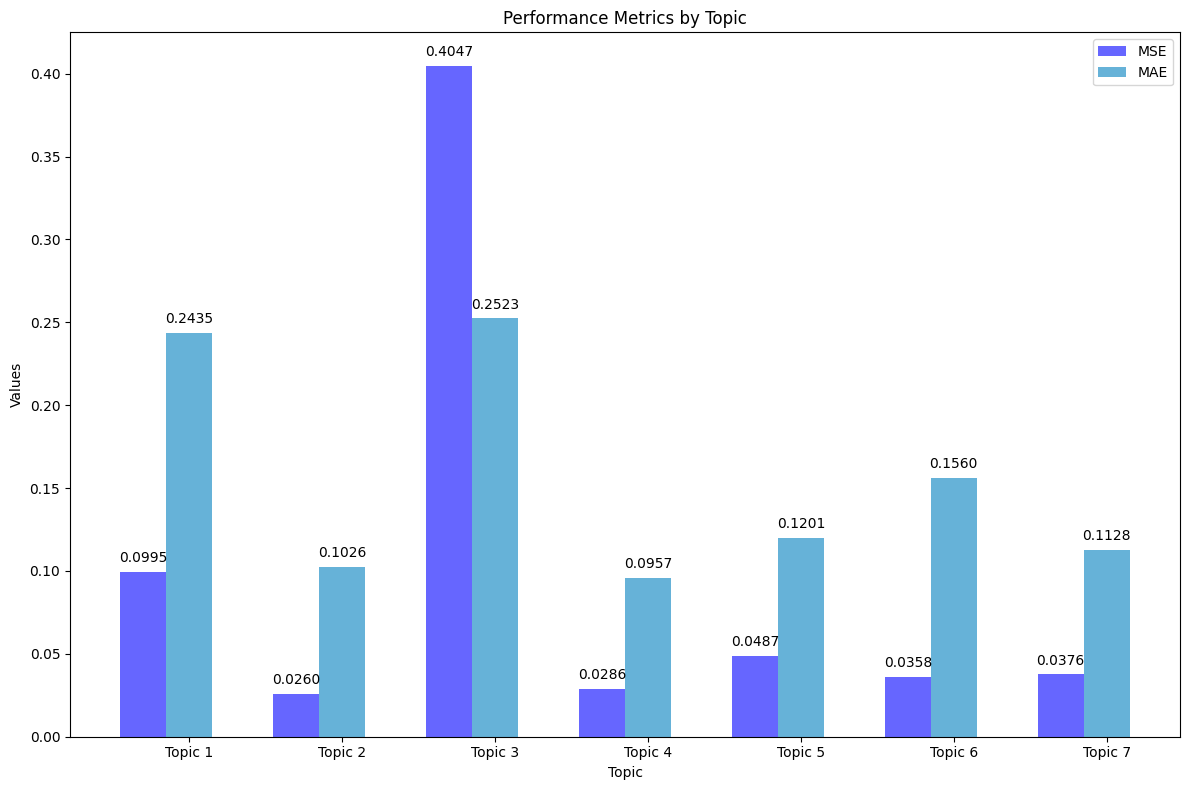

In [316]:

from matplotlib import cm
from matplotlib.cm import get_cmap

topics = np.arange(1, len(topic_regression_metrics) + 1)  
n_groups = len(topics)
bar_width = 0.3  

index = np.arange(n_groups)
mse_pos = index
mae_pos = index + bar_width
r2_pos = index + 2 * bar_width

mse = [stats['MSE'] for stats in topic_regression_metrics.values()]
mae = [stats['MAE'] for stats in topic_regression_metrics.values()]
# r2 = [stats['R2'] for stats in topic_regression_metrics.values()]

cmap = get_cmap('winter')
colors = cmap(np.linspace(0, 1, 3))


# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
mse_bars = ax.bar(mse_pos, mse, bar_width, label='MSE', alpha=0.6, color=colors[0] )
mae_bars = ax.bar(mae_pos, mae, bar_width, label='MAE', alpha=0.6, color=colors[1])
# r2_bars = ax.bar(r2_pos, r2, bar_width, label='R2', alpha=0.6, color=colors[2])


#data labels
for bars in (mse_bars, mae_bars, r2_bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xlabel('Topic')
ax.set_ylabel('Values')
ax.set_title('Performance Metrics by Topic')
ax.set_xticks(index + bar_width)
ax.set_xticklabels([f'Topic {i}' for i in topics])

ax.legend()
plt.tight_layout()
plt.show()


# MSE, MAE, and R2 Line Plot

In [6]:
import numpy as np
import tensorflow as tf
from scipy.sparse import csr_matrix

def convert_to_sparse_tensor(data):
    # Check if the data is already a SparseTensor
    if isinstance(data, tf.SparseTensor):
        return data  # Return as is, no conversion needed

    # Convert from csr_matrix to SparseTensor
    elif isinstance(data, csr_matrix):
        non_zero_places = data.nonzero()
        indices = np.vstack(non_zero_places).T
        values = data.data
        shape = data.shape
        return tf.SparseTensor(indices=indices, values=values, dense_shape=shape)

    else:
        raise TypeError("Input must be a csr_matrix or a TensorFlow SparseTensor")


x_train = convert_to_sparse_tensor(x_train)
x_test = convert_to_sparse_tensor(x_test)

# Ensure the SparseTensor is in the right order (if necessary)
x_train = tf.sparse.reorder(x_train)
x_test = tf.sparse.reorder(x_test)

2024-04-17 12:47:32.846844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/mrtcloud-8/miniconda3/envs/hf_38_john/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
2024-04-17 12:47:33.944904: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64::/usr/local/opencv-4.5.5/build/lib:/usr/local/opencv-4.5.5/build/lib
2024-04-17 12:47:33.944960: W tensorflow/compiler/xla/

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K

####See if you can configure batch size to run faster
y_test = reddit_after_doc_toxicity_scores

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import numpy as np
from scipy.sparse import csr_matrix


model = Sequential([
    Dense(64, activation='relu', input_shape=(5000,)),  # Adjust this line
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', r_squared])


regression_visual_model = model


In [11]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

results = model.evaluate(x_test, y_test, verbose=2)
print("Test MSE:", results[0])
print("Test MAE:", results[1])
print("Test R²:", results[2])

Epoch 1/10


2024-04-17 12:49:41.552183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-17 12:49:41.557371: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc01401cfc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 12:49:41.557397: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-17 12:49:41.568061: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-17 12:49:41.713601: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


758/758 [==============================] - 38s 49ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0320 - r_squared: 0.5323 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.0669 - val_r_squared: -0.2525
Epoch 2/10
758/758 [==============================] - 24s 32ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0169 - r_squared: 0.8548 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.0677 - val_r_squared: -0.2415
Epoch 3/10
758/758 [==============================] - 23s 31ms/step - loss: 6.0881e-04 - mse: 6.0881e-04 - mae: 0.0128 - r_squared: 0.9118 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.0693 - val_r_squared: -0.2987
Epoch 4/10
758/758 [==============================] - 23s 31ms/step - loss: 4.0186e-04 - mse: 4.0186e-04 - mae: 0.0106 - r_squared: 0.9423 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.0678 - val_r_squared: -0.3406
Epoch 5/10
758/758 [==============================] - 23s 30ms/step - loss: 3.3003e-04 - mse: 3.3003e-04 - mae: 0.0096 - r_squared: 0.9530 - val_loss: 

In [ ]:

with open('regression_visual_model.pkl', 'wb') as f:
     pickle.dump(history, f)

# with open('regression_visual_results.pkl', 'rb') as f:
#     res = pickle.load(f)


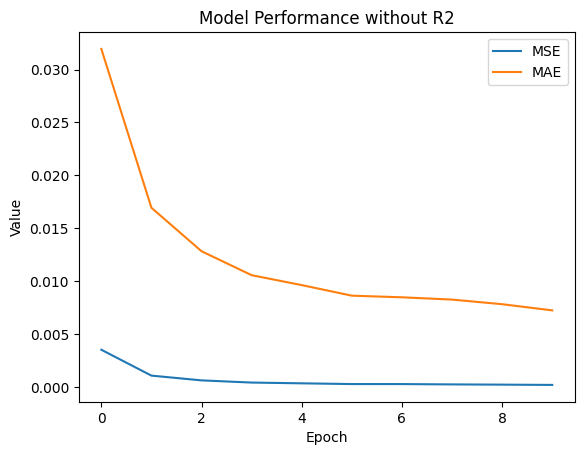

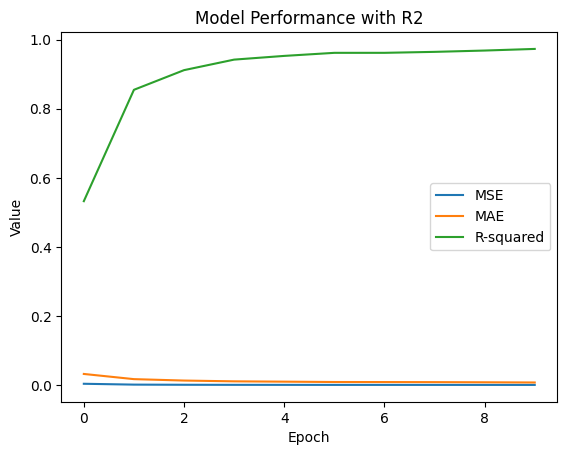

In [13]:
from matplotlib import pyplot

pyplot.plot(history.history['mse'], label='MSE') 
pyplot.plot(history.history['mae'], label='MAE')
# pyplot.plot(history.history['r_squared'])
pyplot.legend()
pyplot.title('Model Performance without R2')
pyplot.ylabel('Value')
pyplot.xlabel('Epoch')
pyplot.show()


pyplot.plot(history.history['mse'], label='MSE') 
pyplot.plot(history.history['mae'], label='MAE')
pyplot.plot(history.history['r_squared'], label='R-squared')
pyplot.legend()
pyplot.title('Model Performance with R2')
pyplot.ylabel('Value')
pyplot.xlabel('Epoch')
pyplot.show()


# See Optimal Parameters

## Twitter Before

Calculating Log-Likelihoods: 100%|██████████████| 14/14 [03:58<00:00, 17.05s/it]


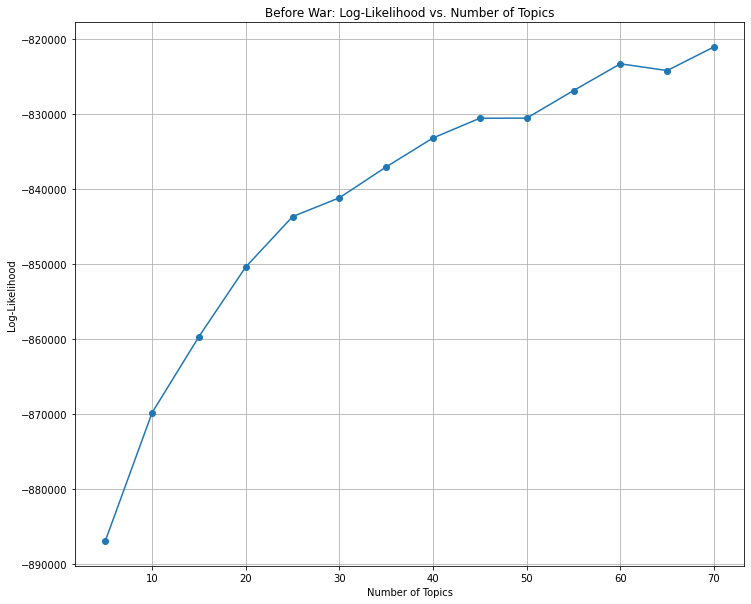

In [62]:
#GET NUM OF TOPICS BEFORE WAR
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_topics in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_topics = 5
max_topics = 70
step_size = 5
topic_range, log_likelihoods = calculate_log_likelihood(twitter_before_tfidf, min_topics, max_topics, step_size)

# Plot log-likelihoods
plt.figure(figsize=(12, 10))
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Topics')
plt.grid(True)
plt.show()

Calculating Log-Likelihoods: 100%|█████████████| 16/16 [37:29<00:00, 140.57s/it]


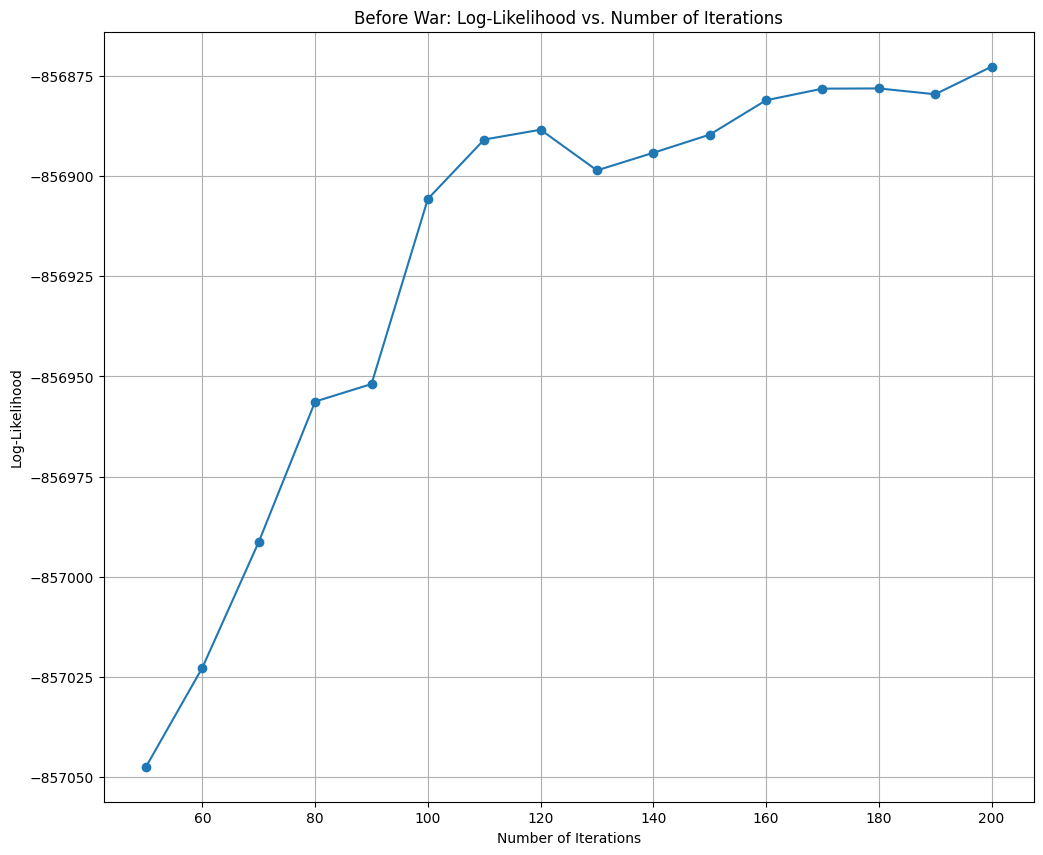

In [13]:
#BEFORE WAR ITERATIONS
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_iter in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=15, max_iter=num_iter, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_iter= 50
max_iter = 200
step_size = 10
topic_range, log_likelihoods = calculate_log_likelihood(twitter_before_tfidf, min_iter, max_iter, step_size)

plt.figure(figsize=(12, 10))
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

## Reddit After

Calculating Log-Likelihoods: 100%|███████████| 14/14 [1:27:38<00:00, 375.61s/it]


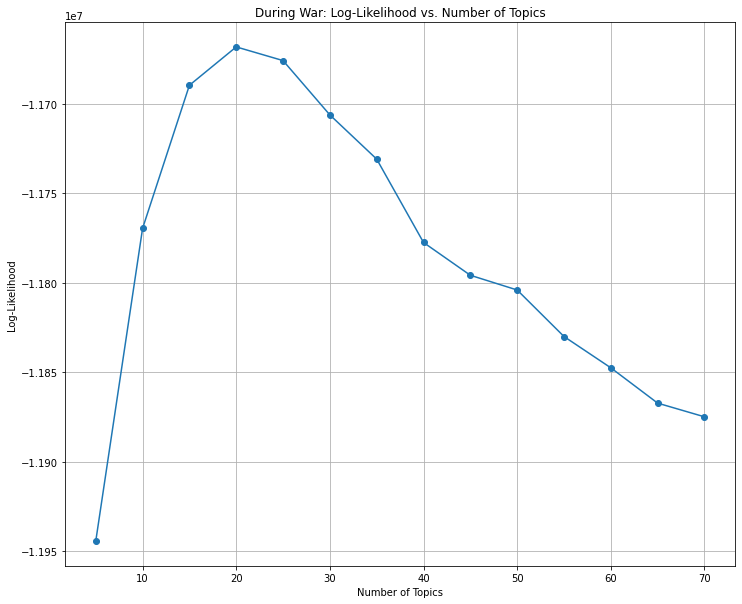

In [67]:
#GET NUM OF TOPICS DURING WAR
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_topics in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_topics = 5
max_topics = 70
step_size = 5
topic_range, log_likelihoods = calculate_log_likelihood(reddit_after_tfidf, min_topics, max_topics, step_size)

# Plot log-likelihoods
plt.figure(figsize=(12, 10))
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('During War: Log-Likelihood vs. Number of Topics')
plt.grid(True)
plt.show()

Calculating Log-Likelihoods: 100%|██████████| 16/16 [9:26:58<00:00, 2126.17s/it]


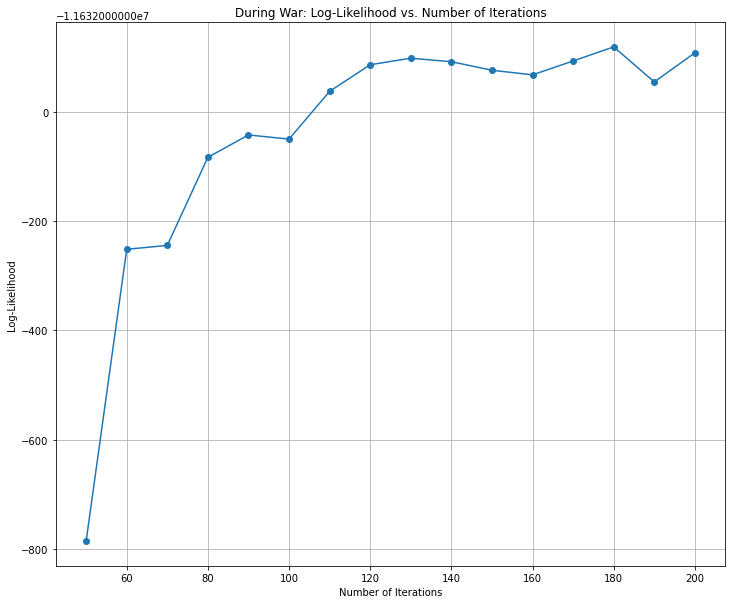

In [65]:
#DURING WAR TERATIONS
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_iter in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=15, max_iter=num_iter, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_iter= 50
max_iter = 200
step_size = 10
topic_range, log_likelihoods = calculate_log_likelihood(reddit_after_tfidf, min_iter, max_iter, step_size)

plt.figure(figsize=(12, 10))
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('During War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

In [87]:

# Range of possible number of topics to evaluate
n_topics_range = range(2, 20)  # For example, evaluating between 2 to 20 topics
log_likelihoods = []
perplexities = []

for n_topics in n_topics_range:
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=120, learning_method='online', learning_offset=50., random_state=0)
    lda.fit(twitter_before)
    log_likelihoods.append(lda.score(twitter_before))  # Higher score (closer to 0) might be better
    perplexities.append(lda.perplexity(twitter_before))  # Lower perplexity might be better

# Plotting log likelihoods
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_topics_range, log_likelihoods)
plt.title('LDA Log Likelihoods')
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')

# Plotting perplexities
plt.subplot(1, 2, 2)
plt.plot(n_topics_range, perplexities)
plt.title('LDA Perplexities')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')

plt.tight_layout()
plt.show()

TypeError: float() argument must be a string or a number, not 'Timestamp'

OrderedDict([(0,
              {'min_toxicity': 0.0005922412965446711,
               'max_toxicity': 0.970398485660553,
               'average_toxicity': 0.06959608731319311,
               'total_toxicity': 43.01038195955334,
               'ngram_count': 618}),
             (1,
              {'min_toxicity': 0.0006038552382960916,
               'max_toxicity': 0.9979667663574219,
               'average_toxicity': 0.06866736385071211,
               'total_toxicity': 52.7365354373469,
               'ngram_count': 768}),
             (2,
              {'min_toxicity': 0.0005649716476909816,
               'max_toxicity': 0.9958173632621765,
               'average_toxicity': 0.09315242458338742,
               'total_toxicity': 108.52257463964634,
               'ngram_count': 1165}),
             (3,
              {'min_toxicity': 0.0006118710734881461,
               'max_toxicity': 0.9954600930213928,
               'average_toxicity': 0.10932963832068329,
               'total

In [158]:
after_war_doc_tox_scores

array([0.        , 0.98667288, 0.11580674, ..., 0.        , 0.        ,
       0.01121919])